# SIMPLE MODEL

## Predicting the Margin of NFL Games using linear regression, 2 Features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from clean3 import clean_games

In [2]:
# gather & pre-process our data (for details, see clean_game_data.ipynb and clean3.py)
df = clean_games('data/games.pickle', start_year=1990)

/Users/ewilens/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [3]:
game_df = df.copy() # to prevent needing to rerun clean_games

Let's start by dropping games where the margin > +/- 50 points. These are outliers, and should not be predicted.

In [4]:
mask = (game_df.margin < 50) & (game_df.margin > -50)
game_df = game_df[mask]

## Feature Selection

See `feature_engineering.ipynb` for more information about the feature selection process.

In [5]:
features = [
    'team_home_game',
    'roll19_wins',
    'roll19_margin_opp',
]

target = 'margin'

print("Number of Features: ", len(features))

Number of Features:  3


In [6]:
all_cols = [c for c in features]
all_cols.append('margin')
model_df = game_df[all_cols]

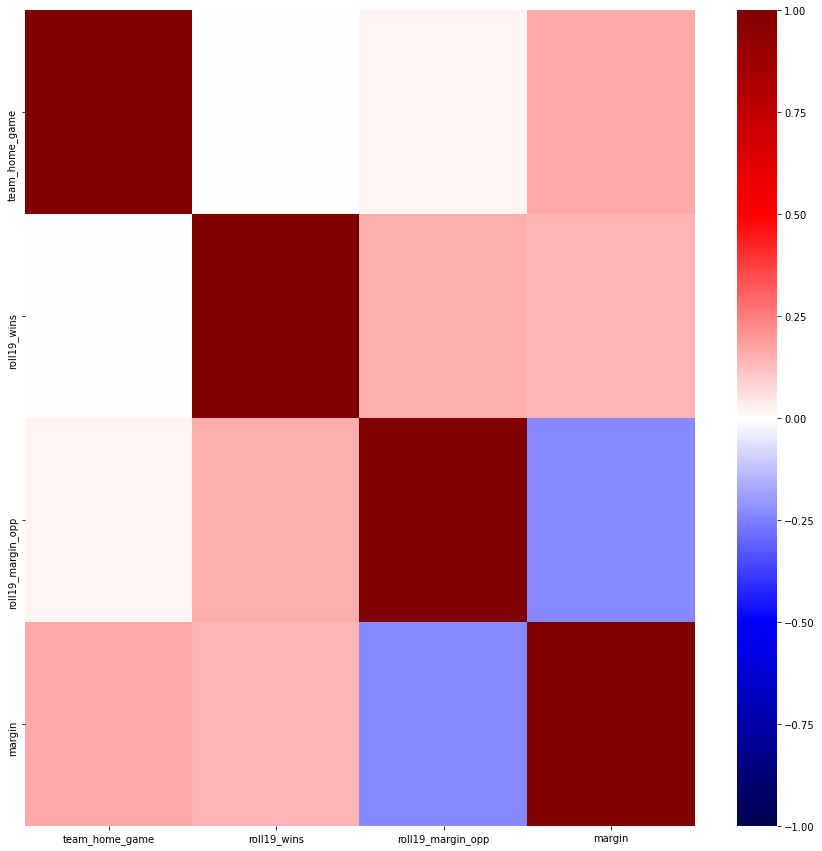

In [7]:

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(game_df[all_cols].corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

In [8]:
game_df.reindex()

,game_id,season_year,week_num,team_year,full_game_date,team,decade,opp,game_day_of_week,game_outcome,...,ewma_third_conv_pct,ewma_third_conv_pct_def,ewma_third_conv_pct_opp,ewma_third_conv_pct_def_opp,ewma_total_yds_off,ewma_total_yds_def,ewma_total_yds_off_opp,ewma_total_yds_def_opp,trend_ewma4_19,trend_ewma4_19_opp
3,atl-rai-1991-09-22,1991,4.0,atl-1991,1991-09-22,atl,199,rai,Sun,W,...,0.414545,0.236831,0.444372,0.384148,196.465,311.192,275.041,317.376,1.513,6.066
4,atl-nor-1991-09-29,1991,5.0,atl-1991,1991-09-29,atl,199,nor,Sun,L,...,0.415208,0.267617,0.323996,0.201953,209.705,302.268,299.874,213.147,1.619,3.706
5,atl-sfo-1991-10-13,1991,7.0,atl-1991,1991-10-13,atl,199,sfo,Sun,W,...,0.366330,0.333438,0.406125,0.399926,189.997,392.980,368.613,283.708,-2.404,-1.918
6,atl-crd-1991-10-20,1991,8.0,atl-1991,1991-10-20,atl,199,crd,Sun,L,...,0.383877,0.390719,0.391666,0.405214,194.481,390.020,288.207,332.186,0.335,-6.537
7,atl-ram-1991-10-27,1991,9.0,atl-1991,1991-10-27,atl,199,ram,Sun,W,...,0.359075,0.395877,0.382289,0.348152,197.839,367.537,279.497,325.905,-0.155,2.082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14773,sfo-was-2020-12-13,2020,14.0,was-2020,2020-12-13,was,202,sfo,Sun,W,...,0.384705,0.372204,0.407858,0.375742,231.228,469.164,363.062,332.646,6.850,-3.700
14774,sea-was-2020-12-20,2020,15.0,was-2020,2020-12-20,was,202,sea,Sun,L,...,0.357849,0.356448,0.407098,0.447129,212.962,466.936,377.980,353.975,5.199,8.691
14775,car-was-2020-12-27,2020,16.0,was-2020,2020-12-27,was,202,car,Sun,L,...,0.393466,0.363534,0.386004,0.478944,220.358,444.073,352.371,356.069,0.341,-1.290
14776,phi-was-2021-01-03,2020,17.0,was-2020,2021-01-03,was,202,phi,Sun,W,...,0.403107,0.368655,0.357061,0.372796,227.742,418.340,355.867,390.934,-2.443,-4.910


In [9]:
X = model_df[features]
y = game_df[target]

## Rigorous Cross-Validation Using Manual K-Fold

I will be using an 80/20 Train/Test split. Note that despite all of the cross-validation we completed in `feature_selection.ipynb`, we still have yet to predict `y_test` using `X_test` data.

The reason we haven't yet used our test set is to prevent overfitting. By holding these out and engineering the features we're including in our model, we should avoid **overfitting**. This would result in our model recognizing outliers as patterns and ultimately the inability to generalize to fresh inputs.

In [10]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, lars_path
from sklearn.metrics import mean_squared_error, mean_absolute_error

def cross_validate_lr(X, y):
    '''
        Performs K-Fold cross-validation on linear regression model and computes model metrics

        Features are scaled using standard scaler.

        ------------------
        Parameters:

        - X: DataFrame or numpy array of features/independent variables from training set
        - y: DataFrame or numpy array of target/dependent variable from training set

        ------------------
        Returns:
        
        - model

        Model metrics with cross-validation: R^2 score for training and validation sets
        with each fold, mean R^2 score for validation set across all folds;
        mean training/validation score ratios, MAE, RMSE across all folds
    '''
    
    train_results = []
    val_results = []
    ratios = []
    maes = []
    rmses = []
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)   # default values
    
    
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):
        
        
        # iterate thru 5 shuffled train/validation sets & collect results
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        
        # standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)
        X_val_scaled = scaler.transform(X_val.values)
        X_test_scaled = scaler.transform(X_test.values) # scaling test set now
        
        # fit linear model to the standardized train dataset
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # validate
        y_pred = model.predict(X_val)
        
        # store results
        train_results.append(model.score(X_train_scaled, y_train))
        val_results.append(model.score(X_val_scaled, y_val))
        ratios.append(model.score(X_train_scaled, y_train) / model.score(X_val_scaled, y_val))
        maes.append(mean_absolute_error(y_val, y_pred))
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))
        
    # summarize results    
    print('Linear regression train R^2:', train_results)
    print('-----------')
    print('Linear regression val R^2: \n ', val_results)
    print('-----------')
    print(f'Linear regression mean val R^2: {np.mean(val_results):.3f} +- {np.std(val_results):.3f}')
    print('-----------')
    print(f'Mean train/val R^2 ratio: {np.mean(ratios):.3f} +- {np.std(ratios):.3f}')
    print('-----------')
    print('Mean MAE: ', np.mean(maes))
    print('-----------')
    print('Mean RMSE: ', np.mean(rmses))
    
    return model, X_test_scaled, y_test, scaler

## Testing Results

In [11]:
model, X_test_scaled, y_test, scaler = cross_validate_lr(X, y)

Linear regression train R^2: [0.12663867941168905, 0.11927172235553396, 0.11912609132941554, 0.11766445213626475, 0.12174034016136526]
-----------
Linear regression val R^2: 
  [0.09758279049515839, 0.12632318051058733, 0.12673853111351918, 0.13383013630053187, 0.11565019899547324]
-----------
Linear regression mean val R^2: 0.120 +- 0.013
-----------
Mean train/val R^2 ratio: 1.023 +- 0.148
-----------
Mean MAE:  193.0853361841178
-----------
Mean RMSE:  249.7195750394696


In [12]:
model.score(X_test_scaled, y_test)

0.11795687530408439

In [13]:
model.intercept_

0.11350856545050353

Not bad! The model generalized well - less than 0.15 lower than our mean cross-validation $R^2$. 

Let's take a look at our features and their corresponding slopes/coefficients

In [14]:
for feature, coef in zip(features, model.coef_):
    print(feature, ': ', coef)

team_home_game :  2.795759291863276
roll19_wins :  2.6004823119359037
roll19_margin_opp :  -3.9076895707211086


In [15]:
model.coef_

array([ 2.79575929,  2.60048231, -3.90768957])

## Plotting Results

In [21]:
model
test_df = pd.DataFrame(X_test_scaled)
test_df.columns = features

test_features = test_df[features].to_numpy()

predictions = model.predict(test_features)

# test_df[features] = scaler.reverse_transform(test_df[features])
test_df['prediction'] = predictions



test_df['actual'] = list(y_test)
test_df['resid'] = test_df['prediction'] - test_df['actual']


test_df

,team_home_game,roll19_wins,roll19_margin_opp,prediction,actual,resid
0,0.999869,-0.241938,0.264918,1.244531,-7.0,8.244531
1,0.999869,-0.905174,-0.898525,4.066170,5.0,-0.933830
2,-1.000131,0.752917,-0.762538,2.255094,7.0,-4.744906
3,-1.000131,-0.905174,0.552001,-7.193555,-27.0,19.806445
4,0.999869,-1.236792,0.174260,-0.988308,-10.0,9.011692
...,...,...,...,...,...,...
2385,0.999869,-0.573556,0.249808,0.441208,-3.0,3.441208
2386,-1.000131,-0.573556,0.159150,-4.796048,7.0,-11.796048
2387,0.999869,0.089680,0.219589,2.284030,3.0,-0.715970
2388,0.999869,-0.573556,0.038273,1.267821,-14.0,15.267821


<AxesSubplot:xlabel='prediction', ylabel='actual'>

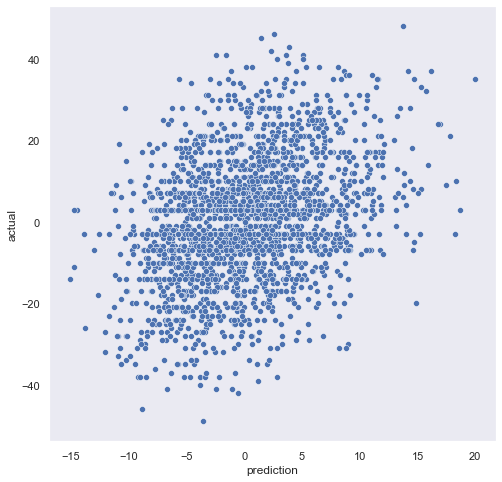

In [22]:
sns.scatterplot(x=test_df.prediction, y=test_df.actual)

In [23]:
def jitter(values, jitter=0.5):
    n = len(values)
    return np.random.uniform(-jitter, + jitter, n) + values

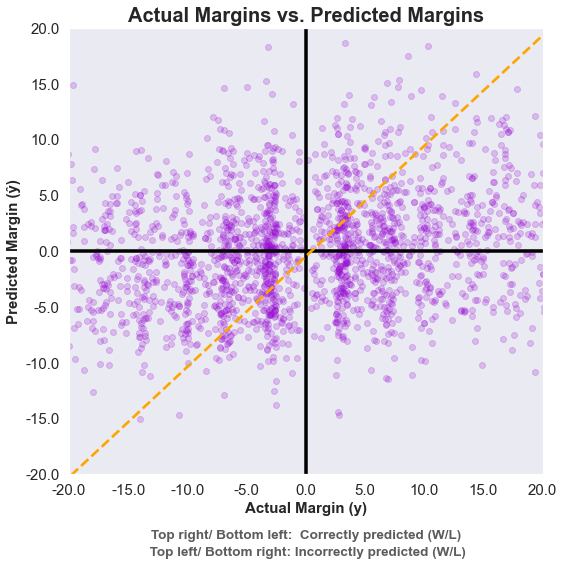

In [26]:


sns.set(rc={'figure.figsize':(8, 8)})
sns.set_style("dark", {'axes.grid': False})
fig, ax = plt.subplots()
ax.scatter(jitter(test_df['actual']), test_df['prediction'], c='darkviolet', alpha=0.2)

# set x/y labels
ax.set_xlabel('Actual Margin (y)', fontsize=15, weight='bold')
ax.set_ylabel('Predicted Margin (ŷ)', fontsize=15, weight='bold')

# add custom-placed 
title = "Actual Margins vs. Predicted Margins"
subtitle_1 = "Top right/ Bottom left:  Correctly predicted (W/L)"
subtitle_2 = " Top left/ Bottom right: Incorrectly predicted (W/L)"

ax.set_title(title, fontsize=20, weight=900)

ax.text(x=.5, y=-0.15, s=subtitle_1, fontsize=13.5, weight='black',
        alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

ax.text(x=.5, y=-0.19, s=subtitle_2, fontsize=13.5, weight='black',
        alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)


# fix tick label sizes & values
ticks = list(np.linspace(-20, 20, 9))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks, size=15)
ax.set_xticklabels(ticks, size=15)

ax.grid=False # removes gridlines

# plot quadrant lines
plt.axvline(x=0, color='black', lw=3.5)
plt.axhline(y=0, color='black', lw=3.5)
plt.xlim((-20, 20))
plt.ylim((-20, 20))
plt.tight_layout()

ax.plot([y.min(), y.max()], [test_df['actual'].min(), test_df['actual'].max()],
        'k--', lw=2.65, color='orange')
plt.savefig('figures/pred_vs_actual.png')
plt.show()

Add to above plot:
- 4 quadrants
- title
- bigger labels
- different style

In [25]:
test_df['predicted_w_l'] = (test_df.prediction > 0) & (test_df.actual > 0)

mask = test_df.season_year == 2019
test_df#[mask]['predicted_w_l']


AttributeError: 'DataFrame' object has no attribute 'season_year'